# Convolutional autoencoding and clustering for automatic puzzeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import sys
import os
import tensorflow as tf
from tensorflow import keras

## Load and Preprocess Data

Size of dataset: 100
Size of image: (453, 422, 4)
Type: <class 'numpy.ndarray'>


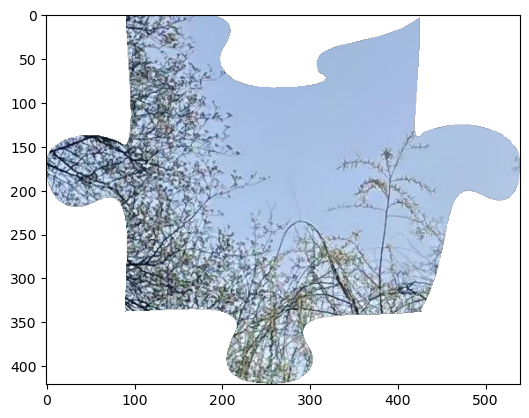

In [2]:
images = [plt.imread(os.path.join('data', 'size-100', 'raster', str(file_num)+'.png')) for file_num in range(100)]

num_images = len(images)
print('Size of dataset: '+ str(num_images))
print('Size of image: '+ str(images[7].shape))
print('Type: '+str(type(images[1])))
plt.imshow(images[79])

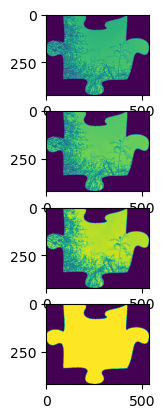

In [3]:
img = images[79]
fig, axs = plt.subplots(4)
for layer in range(0,4):
    axs[layer].imshow(img[:,:,layer])


### Extract shape of the piece and add padding

In [4]:
# Here we get the max length and width for later padding
width_array = [images[i].shape[0] for i in range(num_images)]
length_array = [images[i].shape[1] for i in range(num_images)]
#maxw = np.max(width_array)
#maxl = np.max(length_array)

maxw = 576
maxl = 576
print('max width: '+ str(maxw) + ", max length: " + str(maxl))

# The last layer is the transparency layer, which is basically the shape of the piece
images_bw = [image[:,:,3] for image in images] 

# Here comes the padding
images_p = []
for image in images_bw: 
    # image = images_bw[5]
    w,l = image.shape
    width_ext = int((maxw - w)/2)
    length_ext = int((maxl - l)/2)
    
    #Blocks of zeros to complete the padding
    zero_block_w = np.zeros([width_ext, l]) 
    zero_block_l = np.zeros([maxw,length_ext])

    if w+2*width_ext == maxw: # This is to be sure that all images are going to have the same dimentions
        image_p = np.concatenate((zero_block_w,image,zero_block_w),axis=0) 
    else:
        extraline_w = np.zeros([1,l]) # This extra lines are to complete the dimensions if necessary
        image_p = np.concatenate((zero_block_w,image,zero_block_w,extraline_w),axis=0)

    if l+2*length_ext == maxl:
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l),axis=1)
    else:
        extraline_l = np.zeros([maxw,1])
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l,extraline_l),axis=1)

    # print(image_p.shape)
    # We save the negative of the image on the list
    
    #images_p.append(np.abs(-(image_p-1)))
    images_p.append(image_p)


max width: 576, max length: 576


<class 'numpy.ndarray'>
(576, 576)
1.0
0.0


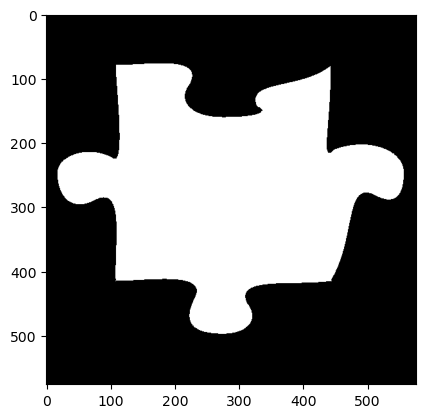

In [5]:
image_bw = images_p[79]
plt.imshow(image_bw,cmap = 'gray')
# plt.imshow(image_bw,cmap = 'Greys')

print(type(image_bw))
print(image_bw.shape)
print(np.max(image_bw))
print(np.min(image_bw))


### Resize Image

In [6]:
# If you want a 64x64 image, size = stride = 9
size = 9
stride = 9
images_rs = []
shape_new_image = (int(image_p.shape[0]/size),int(image_p.shape[0]/size))


for image_p in images_p: 
    image_rs = np.zeros(shape_new_image)
    i_rs = 0
    j_rs = 0
    for i in range(0,image_p.shape[0]-int(size/2),stride):
        for j in range(0,image_p.shape[1]-int(size/2),stride):
            window = image_p[i:i+size,j:j+size].flatten()
            # image_rs[i_rs][j_rs] = np.max(window) # choose how to reduce the size of the image
            image_rs[i_rs][j_rs] = np.mean(window) # choose how to reduce the size of the image
            #image_rs[i_rs][j_rs] = window[0] # choose how to reduce the size of the image
            j_rs += 1
        i_rs += 1
        j_rs = 0
    images_rs.append(image_rs)
    
#plt.imshow(image_rs,cmap = 'Greys')

<class 'numpy.ndarray'>
(64, 64)
1.0
0.0


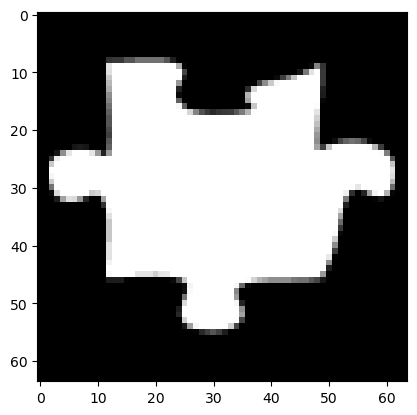

In [7]:
image_rs = images_rs[79]
plt.imshow(image_rs,cmap = 'gray')
print(type(image_rs))
print(image_rs.shape)
print(np.max(image_rs))
print(np.min(image_rs))

In [ ]:
X = np.array(images_rs)
y = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Encode Image Data
### Convolutional Autoencoder

In [8]:
from keras.layers import Conv2D
from keras.layers import Input

from keras.layers import MaxPooling2D, UpSampling2D
from keras.models import Model

from sklearn.model_selection import train_test_split

In [17]:

input_img = Input(shape=(64, 64, 1))

# Encoder
enc_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_pool1)
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv2)
enc_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_pool2)
enc_output = MaxPooling2D((2, 2), padding='same')(enc_conv3)

dec_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_output)
dec_upsample1 = UpSampling2D((2, 2))(dec_conv1)
dec_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(dec_upsample1)
dec_upsample2 = UpSampling2D((2, 2))(dec_conv2)
dec_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)



#dec_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_ouput)
#dec_upsample1 = UpSampling2D((2, 2))(dec_conv2)
#dec_conv3 = Conv2D(8, (3, 3), activation='relu')(dec_upsample2)
#dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
#dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)


autoencoder = Model(input_img, dec_output)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy') 

 

autoencoder.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 16, 16, 8)         584 

In [18]:
# Show some result
autoencoder.fit(X_train, X_train, epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6955
Epoch 2/20
1/1 [==============================] - 0s 220ms/step - loss: 0.6902
Epoch 3/20
1/1 [==============================] - 0s 220ms/step - loss: 0.6863
Epoch 4/20
1/1 [==============================] - 0s 251ms/step - loss: 0.6798
Epoch 5/20
1/1 [==============================] - 0s 266ms/step - loss: 0.6682
Epoch 6/20
1/1 [==============================] - 0s 267ms/step - loss: 0.6484
Epoch 7/20
1/1 [==============================] - 0s 251ms/step - loss: 0.6176
Epoch 8/20
1/1 [==============================] - 0s 282ms/step - loss: 0.5747
Epoch 9/20
1/1 [==============================] - 0s 236ms/step - loss: 0.5329
Epoch 10/20
1/1 [==============================] - 0s 282ms/step - loss: 0.5479
Epoch 11/20
1/1 [==============================] - 0s 235ms/step - loss: 0.4976
Epoch 12/20
1/1 [==============================] - 0s 267ms/step - loss: 0.4656
Epoch 13/20
1/1 [==============================] - 0

### Principal Component Analysis

In [20]:
from sklearn.decomposition import PCA

In [47]:
#
X_flat = np.reshape(X,(100,-1))

num_components = 60
# Create a PCA object and specify the number of components you want to keep
pca = PCA(n_components=num_components)

# Fit the PCA model to the data
pca.fit(X_flat)

# Transform the data to the lower-dimensional space
X_pca = pca.transform(X_flat)

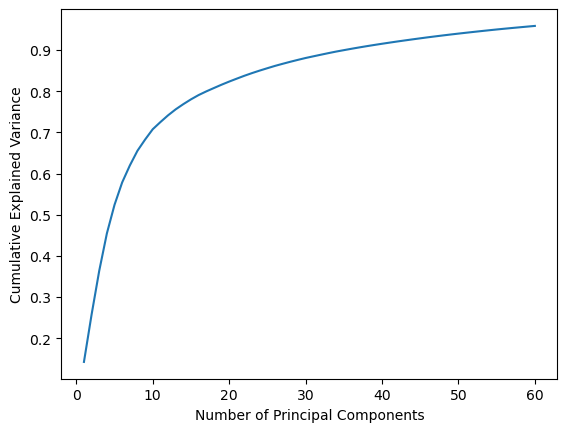

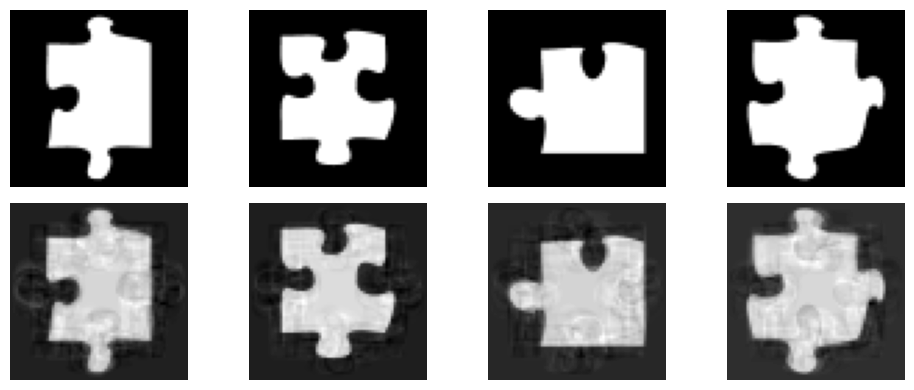

In [48]:
image_shape = (64, 64, 1)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Reconstruct a subset of principal components to visualize the reconstructed images
num_reconstructed_components = num_components
reconstructed_images = pca.inverse_transform(X_pca[:, :num_reconstructed_components])

# Reshape the reconstructed images back to their original shape
reconstructed_images = np.reshape(reconstructed_images, (num_images, *image_shape))

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i in range(4):
    axes[0, i].imshow(X[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

### Investigate the encoding approaches

In [ ]:
# Add code here

## Clustering
### Clustering algorithm 1

In [129]:
# Add code here

In [130]:
# Show some result

### Clustering algorithm 2

In [ ]:
# Add code here

In [ ]:
# Show some result

## Additional Task: Fully Automated Puzzeling Algorithm